In [25]:
# Import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Read Data and convert to local CRS

#pharmacies = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/buffered_pharmacies.geojson").to_crs('2180')
h3 = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/poland_h3_res5.geojson").to_crs('2180')
osm_amenities = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/osm_amenities_with_pharmacies.geojson").to_crs('2180')
population = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/population_by_muninciple.geojson").to_crs('2180')
pollen_gdf = gpd.read_file("C:/Users/alkaye/geodemographics-demonstrator/processed_data/pollen.geojson")

In [27]:
len(h3)

1449

In [28]:
h3

,h3_index,geometry
0,851e0dd3fffffff,"POLYGON ((756373.146 137594.525, 756476.705 12..."
1,851e0dd7fffffff,"POLYGON ((773959.24 137919.837, 774072.685 128..."
2,851e0d9bfffffff,"POLYGON ((782575.161 152267.849, 782694.288 14..."
3,851e2b6bfffffff,"POLYGON ((747432.771 151613.142, 747532.042 14..."
4,851e2b6ffffffff,"POLYGON ((765002.107 151940.364, 765111.302 14..."
...,...,...
1444,851f72cbfffffff,"POLYGON ((454212.844 770130.735, 454143.648 76..."
1445,851f72cffffffff,"POLYGON ((470966.783 770535.907, 470908.861 76..."
1446,851f0dabfffffff,"POLYGON ((412497.778 782080.697, 412400.399 77..."
1447,851f0daffffffff,"POLYGON ((429221.19 782486.769, 429135.081 773..."


In [29]:
# Get pct of population within pharmacy buffers

# Define column lists
pharmacy_columns = ['buffer_area', 'Type'] #['name', 'buffer_area', 'Type']

population_columns = ['total', 'total_male',
       'total_female', '0-4_total', '0-4_males', '0-4_females', '5-9_total',
       '5-9_males', '5-9_females', '10-14_total', '10-14_males',
       '10-14_females', '15-19_total', '15-19_males', '15-19_females',
       '20-24_total', '20-24_males', '20-24_females', '25-29_total',
       '25-29_males', '25-29_females', '30-34_total', '30-34_males',
       '30-34_females', '35-39_total', '35-39_males', '35-39_females',
       '40-44_total', '40-44_males', '40-44_females', '45-49_total',
       '45-49_males', '45-49_females', '50-54_total', '50-54_males',
       '50-54_females', '55-59_total', '55-59_males', '55-59_females',
       '60-64_total', '60-64_males', '60-64_females', '65-69_total',
       '65-69_males', '65-69_females', '70-74_total', '70-74_males', '70-74_females',
       '75-79_total', '75-79_males', '75-79_females', '80-84_total',
       '80-84_males', '80-84_females', '85+_total', '85+_males',
       '85+_females']

# Calculate areas
h3['buffer_area'] = h3.area
population['muninciple_area'] = population.area

# Performing overlay funcion
gdf_joined = gpd.overlay(h3, population, how='union', keep_geom_type=False)
gdf_joined['area_joined'] = gdf_joined.area

# Calculating the pct of munincple area within each pharmacy buffer
gdf_joined['pct_of_muninciple_area'] = (gdf_joined['area_joined'] / gdf_joined['muninciple_area'])

# Use the calculated pct to estimate population within each buffer
for col in population_columns:
    gdf_joined[col] = np.round(gdf_joined[col]*gdf_joined['pct_of_muninciple_area'], 0)

# Groupby pharmcy, sum population columns and take the first row for pharmacy cols
first_dict = {col: 'first' for col in pharmacy_columns}
sum_dict = {col: 'sum' for col in population_columns}
agg_dict = first_dict | sum_dict

gdf_joined = gdf_joined.sort_values('pct_of_muninciple_area').groupby('h3_index').agg(agg_dict).reset_index() #.rename(columns={'id_1': 'id'})

# Add in population density
gdf_joined['population_density'] = (gdf_joined['total']/gdf_joined['buffer_area'])*1000

# Drop Buffer area
# TODO: unless this changes to actual drive time zones
gdf_joined = gdf_joined.drop(columns=['buffer_area'])

# Merge back geometries of pharmacies
gdf_joined = gdf_joined.merge(h3[['h3_index', 'geometry']], on='h3_index', how='left')
gdf_joined = gpd.GeoDataFrame(gdf_joined, crs="EPSG:2180", geometry='geometry')

gdf_joined

,h3_index,Type,total,total_male,total_female,0-4_total,0-4_males,0-4_females,5-9_total,5-9_males,...,75-79_males,75-79_females,80-84_total,80-84_males,80-84_females,85+_total,85+_males,85+_females,population_density,geometry
0,851e0183fffffff,rural,1746.0,853.0,892.0,85.0,45.0,41.0,100.0,48.0,...,19.0,28.0,28.0,11.0,18.0,33.0,8.0,25.0,0.007038,"POLYGON ((554453.414 148031.104, 554443.971 13..."
1,851e0187fffffff,rural,2016.0,1000.0,1016.0,115.0,59.0,55.0,127.0,67.0,...,24.0,33.0,42.0,15.0,27.0,44.0,12.0,32.0,0.008123,"POLYGON ((571973.109 148355.43, 571973.51 1389..."
2,851e0193fffffff,urban-rural,4687.0,2290.0,2397.0,229.0,120.0,109.0,269.0,127.0,...,50.0,75.0,76.0,28.0,48.0,90.0,23.0,67.0,0.018946,"POLYGON ((545716.872 162002.978, 545702.684 15..."
3,851e0197fffffff,urban-rural,43019.0,20516.0,22502.0,1829.0,960.0,869.0,2318.0,1195.0,...,563.0,921.0,975.0,342.0,632.0,1116.0,294.0,821.0,0.173812,"POLYGON ((563219.122 162329.203, 563214.814 15..."
4,851e04a7fffffff,rural,437.0,212.0,225.0,19.0,9.0,10.0,21.0,11.0,...,4.0,6.0,13.0,4.0,9.0,10.0,4.0,6.0,0.001795,"POLYGON ((432676.843 230134.531, 432598.219 22..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,851f734bfffffff,rural,751.0,386.0,364.0,27.0,14.0,14.0,36.0,19.0,...,9.0,14.0,14.0,4.0,9.0,15.0,3.0,12.0,0.003408,"POLYGON ((580059.453 734086.894, 580074.475 72..."
1445,851f734ffffffff,rural,286.0,147.0,138.0,11.0,5.0,5.0,15.0,8.0,...,3.0,5.0,5.0,1.0,4.0,5.0,1.0,4.0,0.001297,"POLYGON ((596900.909 734489.315, 596927.203 72..."
1446,851f736bfffffff,rural,4492.0,2247.0,2245.0,176.0,90.0,87.0,230.0,130.0,...,60.0,74.0,89.0,23.0,67.0,110.0,24.0,84.0,0.020304,"POLYGON ((622236.122 722007.49, 622279.084 713..."
1447,851f736ffffffff,rural,3164.0,1593.0,1572.0,122.0,66.0,56.0,159.0,80.0,...,33.0,55.0,59.0,17.0,42.0,73.0,16.0,57.0,0.014296,"POLYGON ((639105.361 722408.978, 639159.592 71..."


<Axes: >

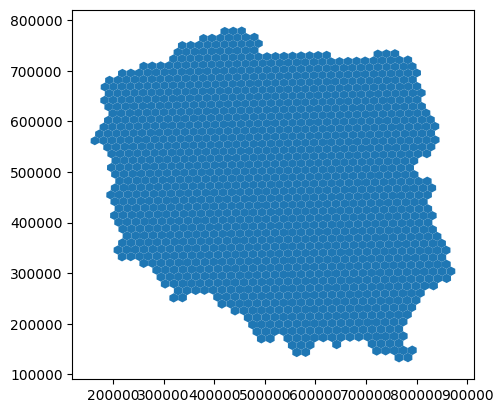

In [30]:
gdf_joined.plot()

In [31]:
# Count ameneties within each buffer

# ameneties_within_buffers = osm_amenities.sjoin(h3, predicate='intersects', how='left')
# ameneties_within_buffers = ameneties_within_buffers.groupby(['id_right', 'type']).agg({'id_left': 'count'}).reset_index()
# ameneties_within_buffers = ameneties_within_buffers.pivot(index='id_right', columns='type', values='id_left').fillna(0).reset_index()
# ameneties_within_buffers = ameneties_within_buffers.rename(columns={'id_right': 'id'})
# ameneties_within_buffers

ameneties_within_buffers = osm_amenities.sjoin(h3, predicate='intersects', how='left')
ameneties_within_buffers = ameneties_within_buffers.groupby(['h3_index', 'type']).agg({'id': 'count'}).reset_index()
ameneties_within_buffers = ameneties_within_buffers.pivot(index='h3_index', columns='type', values='id').fillna(0).reset_index()
#ameneties_within_buffers = ameneties_within_buffers.rename(columns={'h3_index': 'id'})
ameneties_within_buffers

type,h3_index,dentist,hospital,nursing_home,pharmacy,place_of_worship,school,university
0,851e0187fffffff,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,851e0193fffffff,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,851e0197fffffff,5.0,0.0,0.0,23.0,5.0,4.0,0.0
3,851e04b3fffffff,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,851e04b7fffffff,0.0,0.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1329,851f72cffffffff,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1330,851f72dbfffffff,0.0,0.0,0.0,1.0,3.0,0.0,0.0
1331,851f736bfffffff,0.0,0.0,0.0,2.0,1.0,1.0,0.0
1332,851f736ffffffff,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
# Merge amenties with main gdf

gdf_final = gdf_joined.merge(ameneties_within_buffers, on='h3_index', how='left').fillna(0)
gdf_final = gdf_final.merge(pollen_gdf[['h3_index', 'pollen_level']], on='h3_index', how='left')
gdf_final

,h3_index,Type,total,total_male,total_female,0-4_total,0-4_males,0-4_females,5-9_total,5-9_males,...,population_density,geometry,dentist,hospital,nursing_home,pharmacy,place_of_worship,school,university,pollen_level
0,851e0183fffffff,rural,1746.0,853.0,892.0,85.0,45.0,41.0,100.0,48.0,...,0.007038,"POLYGON ((554453.414 148031.104, 554443.971 13...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,851e0187fffffff,rural,2016.0,1000.0,1016.0,115.0,59.0,55.0,127.0,67.0,...,0.008123,"POLYGON ((571973.109 148355.43, 571973.51 1389...",0.0,0.0,0.0,0.0,2.0,0.0,0.0,1
2,851e0193fffffff,urban-rural,4687.0,2290.0,2397.0,229.0,120.0,109.0,269.0,127.0,...,0.018946,"POLYGON ((545716.872 162002.978, 545702.684 15...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,851e0197fffffff,urban-rural,43019.0,20516.0,22502.0,1829.0,960.0,869.0,2318.0,1195.0,...,0.173812,"POLYGON ((563219.122 162329.203, 563214.814 15...",5.0,0.0,0.0,23.0,5.0,4.0,0.0,1
4,851e04a7fffffff,rural,437.0,212.0,225.0,19.0,9.0,10.0,21.0,11.0,...,0.001795,"POLYGON ((432676.843 230134.531, 432598.219 22...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,851f734bfffffff,rural,751.0,386.0,364.0,27.0,14.0,14.0,36.0,19.0,...,0.003408,"POLYGON ((580059.453 734086.894, 580074.475 72...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1445,851f734ffffffff,rural,286.0,147.0,138.0,11.0,5.0,5.0,15.0,8.0,...,0.001297,"POLYGON ((596900.909 734489.315, 596927.203 72...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1446,851f736bfffffff,rural,4492.0,2247.0,2245.0,176.0,90.0,87.0,230.0,130.0,...,0.020304,"POLYGON ((622236.122 722007.49, 622279.084 713...",0.0,0.0,0.0,2.0,1.0,1.0,0.0,1
1447,851f736ffffffff,rural,3164.0,1593.0,1572.0,122.0,66.0,56.0,159.0,80.0,...,0.014296,"POLYGON ((639105.361 722408.978, 639159.592 71...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


<Axes: >

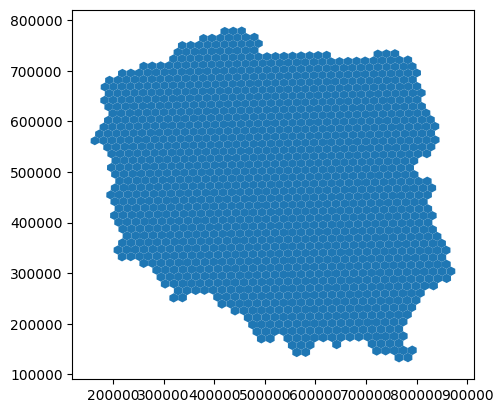

In [33]:
gdf_final.plot()

In [34]:
# Convert to WGS and save
gdf_final = gdf_final.to_crs('4236')
gdf_final.to_file('C:/Users/alkaye/geodemographics-demonstrator/processed_data/h3_preprocessed.geojson')

<Axes: >

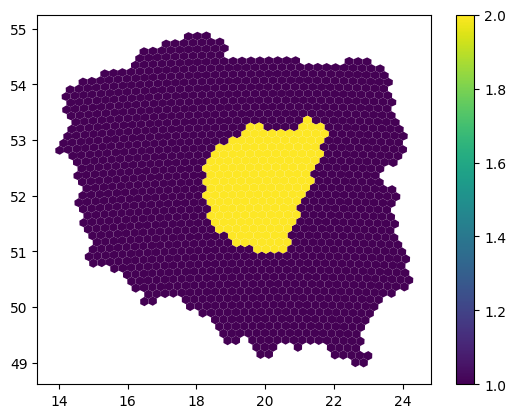

In [35]:
gdf_final.plot(column='pollen_level', legend=True)